# Initialization of Model Weights

The model's weights can be initialized randomly or from a pre-trained model.

## Random Initialization

In practice, we seldom need to spend time tuning initialization parameters, because the default initialization method in deep learning libraries is often sufficient.

This [blog post](https://www.deeplearning.ai/ai-notes/initialization/) from deeplearning.ai gives a great interative introduction of random initialization methods using toy examples. This [executable tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial4/Optimization_and_Initialization.html) provides sample code and visualization tools to diagnose random initialization issues.

Xavier initialization {footcite}`xavier` (by Xavier Glorot) is a popular method and it has two main variants:

- Xavier uniform:

$$W\sim U\left[-\frac{\sqrt{6}}{\sqrt{d_x+d_y}}, \frac{\sqrt{6}}{\sqrt{d_x+d_y}}\right]$$

- Xavier normal:

$$W\sim \mathcal{N}\left(0,\frac{2}{d_x+d_y}\right)$$

where $W$ holds the weights of the layer, $d_x$ and $d_y$ are the input and output dimensions of the weight tensor, respectively. They are also called "fan in" and "fan out". Initialized this way, the training process is made more stable through the following properties:

1. The mean of the activations is close to zero
2. The variance of the activations is roughly the same across all layers
3. The variance of the gradients is roughly the same across all layers

Later, Kaiming He proposed to multiply by 2 the variance of the Xavier initialization. This is the default initialization method in PyTorch for linear and conv layers (for example, see [how conv layers in PyTorch are initialized](https://github.com/pytorch/pytorch/blob/v1.12.1/torch/nn/modules/conv.py#L144)).

### Visualizing the Activations and Gradients

First, let's create visualization and initialization functions (adapted from [example notebok](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial4/Optimization_and_Initialization.html)):

#### Visualization Functions

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

##############################################################
def plot_dists(named_tensors, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(named_tensors)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3, 2.5))
    fig_index = 0
    # for key in sorted(val_dict.keys()):
    for key, tensor in named_tensors:
        key_ax = ax[fig_index%columns]
        sns.histplot(tensor, ax=key_ax, color=color, bins=50, stat=stat,
                     kde=use_kde and ((tensor.max()-tensor.min())>1e-8)) # Only plot kde if there is variance
        key_ax.set_title(f"{key} " + (r"(%i $\to$ %i)" % (tensor.shape[1], tensor.shape[0]) if len(tensor.shape)>1 else ""))
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig


def plot_dists_(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index%columns]
        sns.histplot(val_dict[key], ax=key_ax, color=color, bins=50, stat=stat,
                     kde=use_kde and ((val_dict[key].max()-val_dict[key].min())>1e-8)) # Only plot kde if there is variance
        key_ax.set_title(f"{key} " + (r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape)>1 else ""))
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig
 
##############################################################

def visualize_weight_distribution(model, color="C0"):
    weights = []
    for name, param in model.named_parameters():
        # if name.endswith(".bias"):
        #     continue
        if "weight" in name:
            # key_name = f"Layer {name.split('.')[1]}"
            key_name = name
            # weights[key_name] = param.detach().view(-1).cpu().numpy()
            weights.append((key_name, param.detach().view(-1).cpu().numpy()))
    
    ## Plotting
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close() 
    
##############################################################
    
def visualize_gradients(model, dataloader, device="cuda", color="C0", print_variance=False):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    model.eval()
    small_loader = dataloader
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    
    # Pass one batch through the network, and calculate the gradients for the weights
    model.zero_grad()
    preds = model(imgs)
    loss = F.cross_entropy(preds, labels) # Same as nn.CrossEntropyLoss, but as a function instead of module
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    # grads = {name: params.grad.view(-1).cpu().clone().numpy() for name, params in model.named_parameters() if "weight" in name}
    grads = [(name, params.grad.view(-1).cpu().clone().numpy()) for name, params in model.named_parameters() if "weight" in name]
    model.zero_grad()
    
    ## Plotting
    fig = plot_dists(grads, color=color, xlabel="Grad")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close() 
    
    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")

##############################################################

def visualize_activations(model, dataloader, device="cuda", color="C0", print_variance=False):
    model.eval()
    small_loader = dataloader
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    
    # Pass one batch through the network, and calculate the gradients for the weights
    # feats = imgs.view(imgs.shape[0], -1)
    feats = imgs
    activations = []
    with torch.no_grad():
        for layer_index, layer in tqdm(enumerate(model.layers)):
            feats = layer(feats)
            if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
                # activations[f"Layer {layer_index} ({type(layer).__name__})"] = feats.view(-1).detach().cpu().numpy()
                activations.append((f"Layer {layer_index} ({type(layer).__name__})", feats.view(-1).detach().cpu().numpy()))
    
    ## Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close() 
    
    if print_variance:
        for key, tensor in activations:
            print(f"{key} - Variance: {np.var(tensor)}")

            
##############################################################

#### Initialization Functions

In [38]:
def const_init(model, c=0.0):
    for name, param in model.named_parameters():
        param.data.fill_(c)

def var_init(model, std=0.01):
    for name, param in model.named_parameters():
        param.data.normal_(std=std)

def xavier_uniform_init(model):
    def init_layer(layer):
        if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
            torch.nn.init.xavier_uniform_(layer.weight)
            if hasattr(layer, "bias"):
                if layer.bias is not None:
                    layer.bias.data.fill_(0)
    
    model.apply(init_layer)

def kaiming_uniform_init(model):
    def init_layer(layer):
        if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
            torch.nn.init.kaiming_uniform_(layer.weight)
            if hasattr(layer, "bias"):
                if layer.bias is not None:
                    layer.bias.data.fill_(0)
    
    model.apply(init_layer)

### Model and Dataset

For the purpose of making it run faster, we use a simple convnet rather than ResNet. And CIFAR10 is used as the dataset to train the model on.

In [4]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten(1)
        self.fc = nn.Linear(32, 10)
        self.layers = nn.ModuleList([
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
            self.avgpool,
            self.flatten,
            self.fc
        ])
        
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [5]:
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

train_dataloader = DataLoader(CIFAR10(root="data", train=True, download=True, transform=ToTensor()), batch_size=32, shuffle=False)
val_dataloader = DataLoader(CIFAR10(root="data", train=False, download=True, transform=ToTensor()), batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### See the Effect of Different Intialization Methods

#### Constant Initialization

Initializing all weights to a small number, the gradients are sparse and almost zero. Increasing the constant has little help, and the activation becomes too high. The model is not able to learn anything in this mode, until the weights get far away from the initialized values.

In [6]:
def visualize_weights_gradients_activations(model):
    visualize_weight_distribution(model)
    visualize_gradients(model, val_dataloader, device="cpu")
    print("Now visualizing activations. It can take a bit...")
    visualize_activations(model, val_dataloader, device="cpu", print_variance=True)

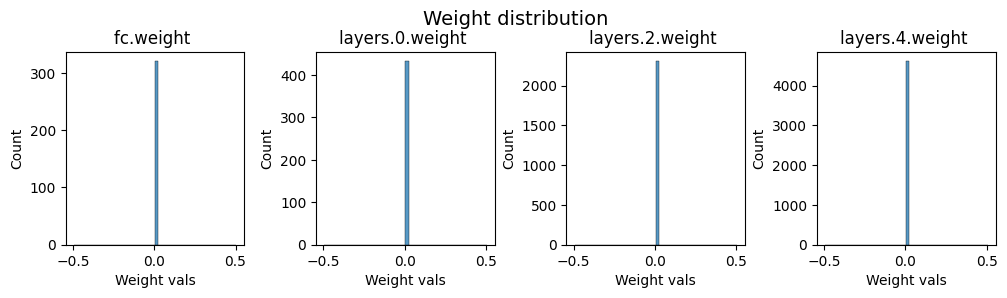

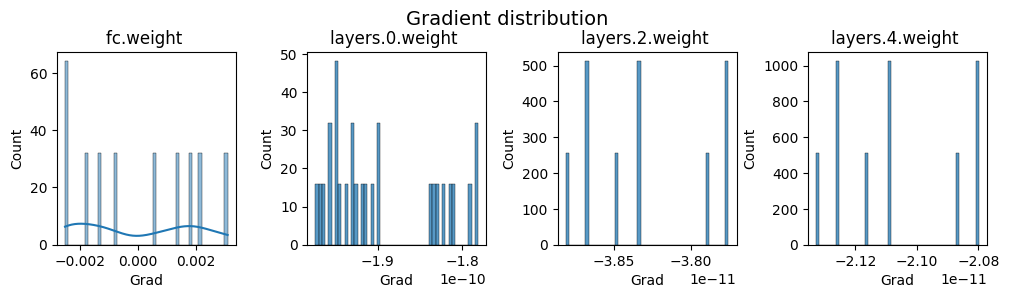

Now visualizing activations. It can take a bit...


0it [00:00, ?it/s]

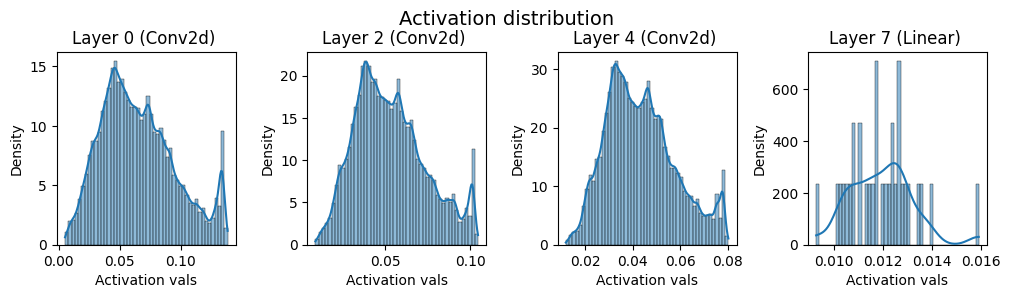

Layer 0 (Conv2d) - Variance: 0.000905229477211833
Layer 2 (Conv2d) - Variance: 0.0004272360529284924
Layer 4 (Conv2d) - Variance: 0.00020684821356553584
Layer 7 (Linear) - Variance: 1.7030531580530806e-06


In [7]:
model = SimpleModel()
const_init(model, c=0.005)
visualize_weights_gradients_activations(model)

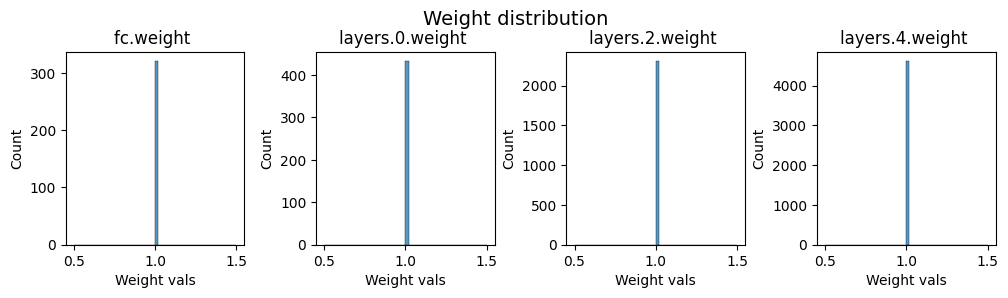

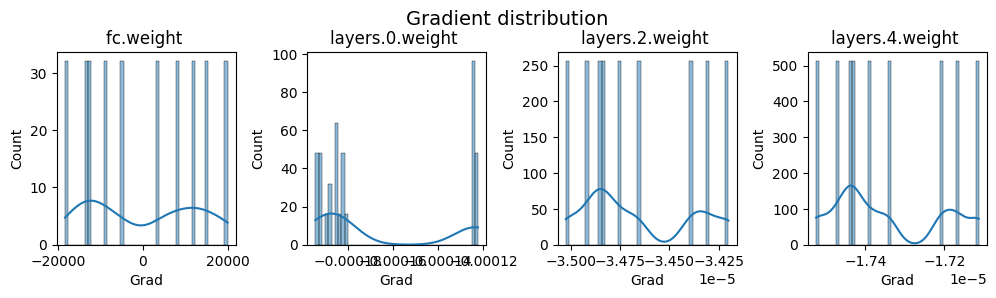

Now visualizing activations. It can take a bit...


0it [00:00, ?it/s]

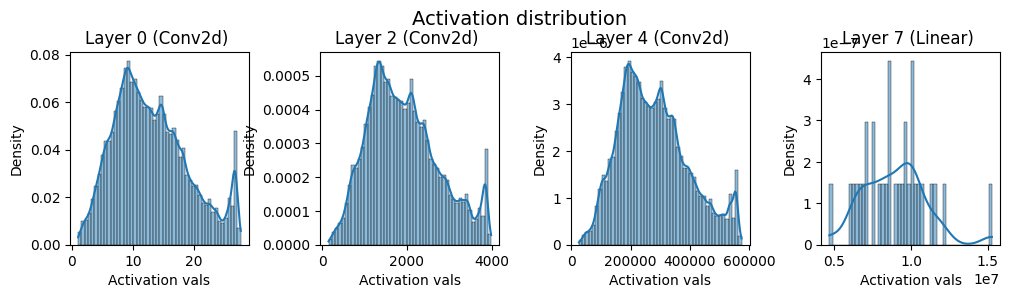

Layer 0 (Conv2d) - Variance: 36.20917892456055
Layer 2 (Conv2d) - Variance: 683578.125
Layer 4 (Conv2d) - Variance: 13238294528.0
Layer 7 (Linear) - Variance: 4359820148736.0


In [8]:
model = SimpleModel()
const_init(model, c=1)
visualize_weights_gradients_activations(model)

What if we draw random samples from a normal distribution? How much variance should the random initialization have?

#### Vanishing Gradients

When the variance of initialized values is small, the gradients at  the earlier layers (0 and 2) are almost zero (1e-5). This can cause the model to learn very slowly.

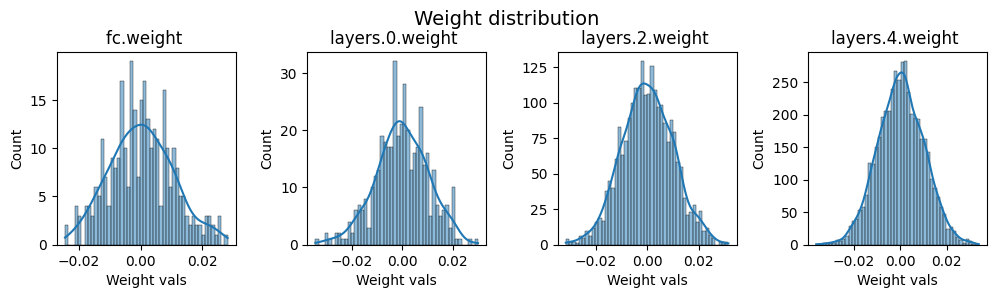

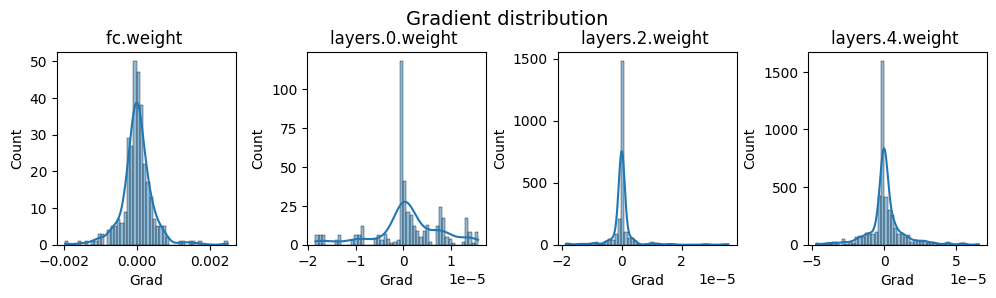

Now visualizing activations. It can take a bit...


0it [00:00, ?it/s]

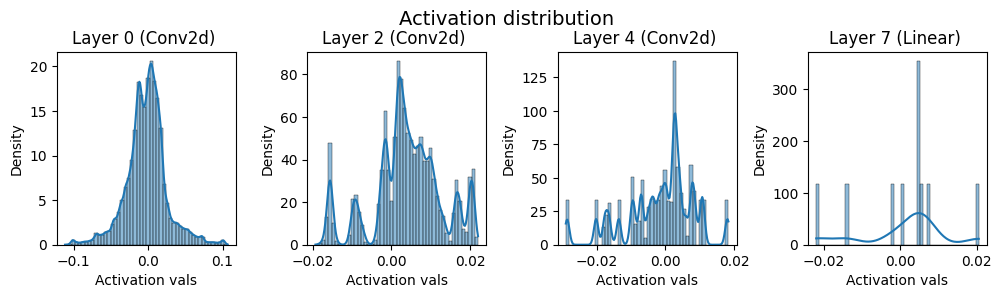

Layer 0 (Conv2d) - Variance: 0.0007303644670173526
Layer 2 (Conv2d) - Variance: 7.553636532975361e-05
Layer 4 (Conv2d) - Variance: 9.660515206633136e-05
Layer 7 (Linear) - Variance: 0.00012513234105426818


In [9]:
model = SimpleModel()
var_init(model, std=0.01)
visualize_weights_gradients_activations(model)

#### Exploding Gradients and Activation

On the other hand, if the variance of initialized values is large, the gradients also tend to have a large magnitude. The activation at the end of the network (e.g. layer 7) is very high. This problem is more prominent when we use deeper networks. This can cause the model to be high unstable and crashes due to NaN values.

It becomes clear we need to strike a balance, having a variance not too high and not too low. But how to find that balance? It will be hard to find one that gives us a good activation and gradient distribution across layers. And when the number of layers changes, you may need to tune the variance again.

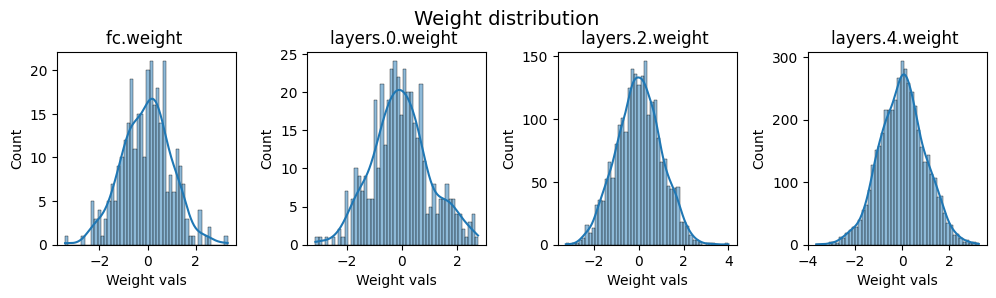

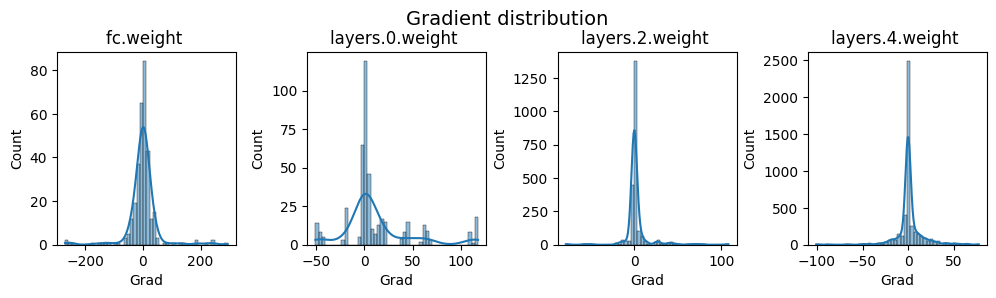

Now visualizing activations. It can take a bit...


0it [00:00, ?it/s]

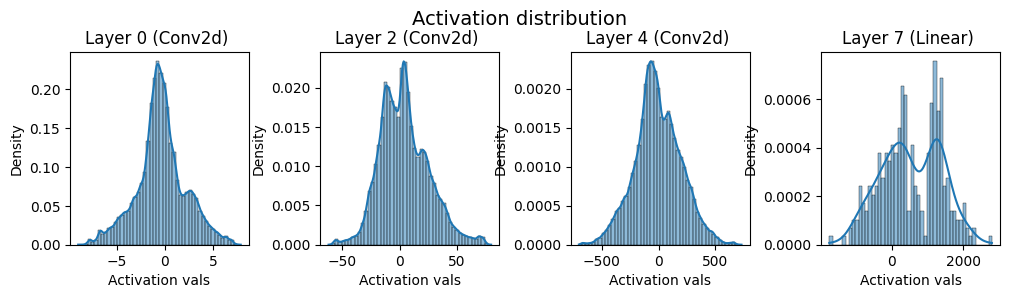

Layer 0 (Conv2d) - Variance: 6.471884250640869
Layer 2 (Conv2d) - Variance: 446.0733642578125
Layer 4 (Conv2d) - Variance: 41183.9375
Layer 7 (Linear) - Variance: 692235.1875


In [10]:
model = SimpleModel()
var_init(model, std=1)
visualize_weights_gradients_activations(model)

#### Xavier Initialization

Now let's use Xavier initialization to handle the variance of weights automatically. As we can see, the gradient and activation distributions are much more reasonable.

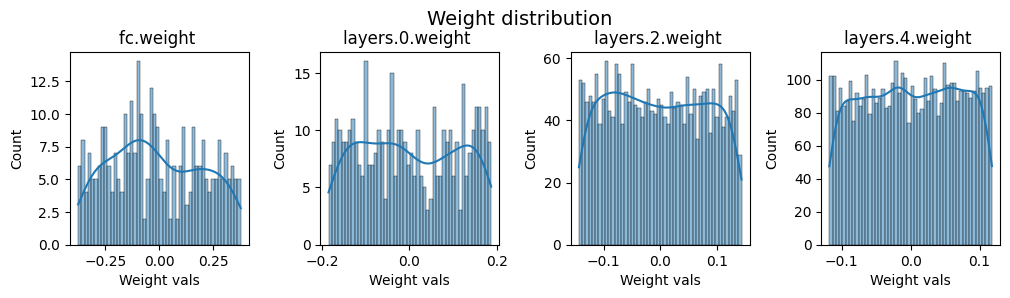

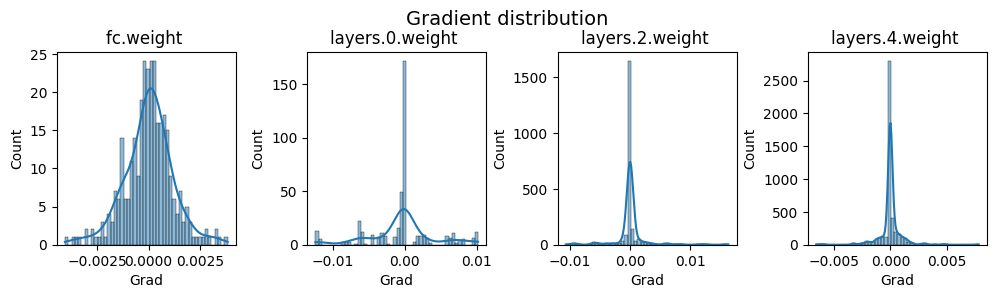

Now visualizing activations. It can take a bit...


0it [00:00, ?it/s]

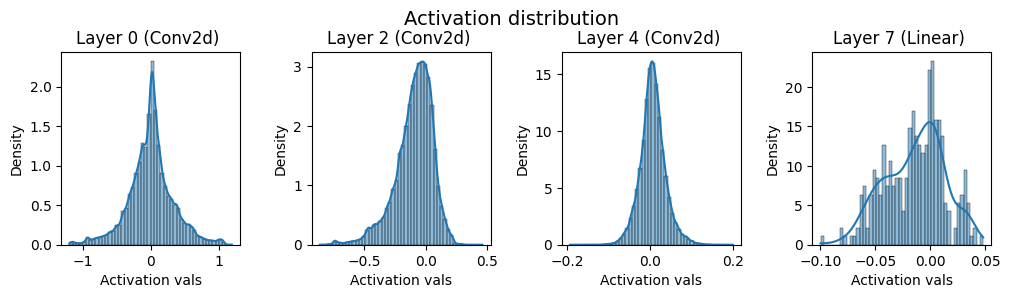

Layer 0 (Conv2d) - Variance: 0.10684434324502945
Layer 2 (Conv2d) - Variance: 0.022641852498054504
Layer 4 (Conv2d) - Variance: 0.0009143133647739887
Layer 7 (Linear) - Variance: 0.0007290925132110715


In [11]:
model = SimpleModel()
xavier_uniform_init(model)
visualize_weights_gradients_activations(model)

#### Kaiming Initialization

Kaiming initialization is also a great choice:

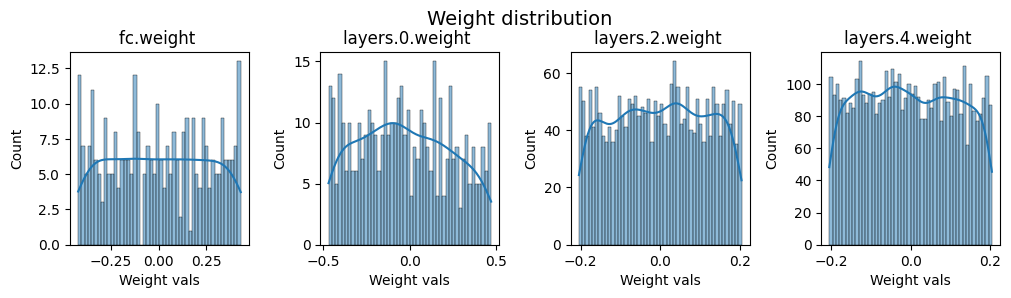

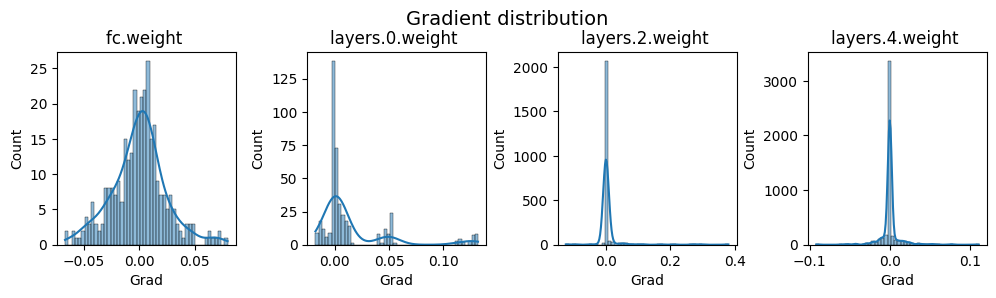

Now visualizing activations. It can take a bit...


0it [00:00, ?it/s]

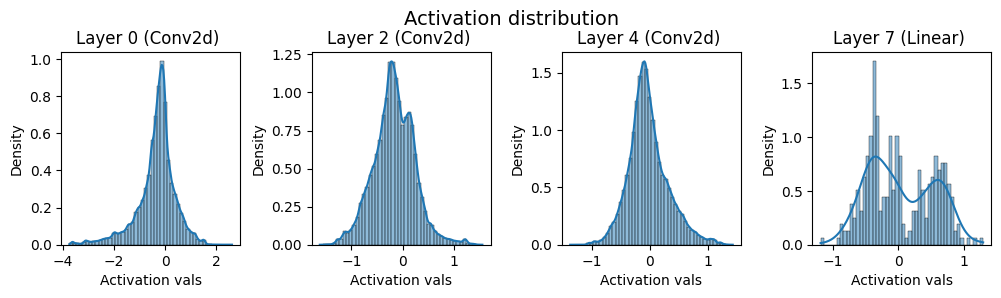

Layer 0 (Conv2d) - Variance: 0.5570183992385864
Layer 2 (Conv2d) - Variance: 0.16034908592700958
Layer 4 (Conv2d) - Variance: 0.1166415885090828
Layer 7 (Linear) - Variance: 0.24810270965099335


In [12]:
model = SimpleModel()
kaiming_uniform_init(model)
visualize_weights_gradients_activations(model)

## Initialization from a Pre-trained Model: Transfer Learning

Besides random initialization, there is another choice that is actually more commonly used: initialization from a pre-trained model. And it is better known name: "Transfer Learning".

When using transfer learning, random initialization may still be used. As often times, the pre-trained model serves as the backbone of a new model you want to fine tune. The new model includes additional layers which still need to be intialized with reasonable random values.

With libraries like `torchvision` and `timm`, it is easy to initialize a pre-trained model:

```{footbibliography}
```

In [13]:
from torchvision.models.resnet import resnet18

net = resnet18(pretrained=True)  # This loads ImageNet weights.

/home/ubuntu/anaconda3/envs/p38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/p38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Showdown

Now is our favorate part: the showdown of different initialization recipes. To save time, only a subset of training and validation data is used: controlled by `limit_train_batches` and `limit_val_batches` of the Trainer class.

In [14]:
!pip install pytorch-lightning==1.6.4 torchmetrics

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [43]:
import pytorch_lightning as pl
from torchmetrics import Accuracy


class ImageClassifier(pl.LightningModule):
    def __init__(self, net: nn.Module, num_classes=10):
        super().__init__()
        self.net = net
        self.val_accuracy = Accuracy(num_classes=num_classes)
    
    def forward(self, x):
        return self.net(x)
    
    def configure_optimizers(self):
        # return torch.optim.Adam(self.parameters(), lr=0.001)
        return torch.optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
    
    def loss(self, y_hat, y):
        return F.cross_entropy(y_hat, y)
    
    def training_step(self, batch, batch_idx=None):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)

        # Note: The return value can be None, a loss tensor, or a dictionary with a "loss" key.
        return {"loss": loss}
    
    def validation_step(self, batch, batch_idx=None):
        x, y = batch
        y_hat = self(x)
        self.val_accuracy.update(preds=y_hat, target=y)
        val_loss = self.loss(y_hat, y)
        return {"loss": val_loss}

In [48]:
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import Callback, EarlyStopping


class ImageClassifierCallback(Callback):

    def __init__(self, *args, **kwargs):
      super().__init__(*args, **kwargs)
      self.current_epoch = 0
    
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        super().on_train_batch_end(trainer, pl_module, outputs, batch, batch_idx)
        loss = outputs["loss"]
        self.log(name="loss", value=loss.item(), on_step=True, prog_bar=True)
    
    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
        super().on_validation_batch_end(trainer, pl_module, outputs, batch, batch_idx, dataloader_idx)
        loss = outputs["loss"]
        self.log(name="val_loss", value=loss.item(), on_step=True)
        self.log(name="val_acc", value=pl_module.val_accuracy.compute(), on_step=True)
        return {"loss": loss}
    
    def on_validation_epoch_end(self, trainer, pl_module, *args, **kwargs):
        super().on_validation_epoch_end(trainer, pl_module, *args, **kwargs)
        avg_acc = pl_module.val_accuracy.compute()
        self.log('val_acc', avg_acc, prog_bar=True)
        print("epoch", self.current_epoch, "--", "val_accuracy:", avg_acc.item())
        self.current_epoch += 1


def create_trainer(name="image_classifier"):
    trainer = Trainer(
        limit_train_batches=300,
        limit_val_batches=100,
        max_epochs=2,
        logger=CSVLogger(save_dir="csv_logs", name=name),
        callbacks=[ImageClassifierCallback(), EarlyStopping(monitor="val_acc", mode="max", patience=5)],
        accelerator="gpu"
    )
    return trainer

### Initialize from a Pre-trained Model

In [49]:
import torchvision

num_classes = 10
net = torchvision.models.resnet18(pretrained=True)
net.fc = nn.Linear(net.fc.in_features, num_classes)
model = ImageClassifier(net=net, num_classes=num_classes)
create_trainer("pretrained").fit(model, train_dataloader, val_dataloader)

/home/ubuntu/anaconda3/envs/p38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/p38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: csv_logs/pretrained
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type     | Params
------------------------------------------
0 | net          | ResNet   | 11.2 M

Sanity Checking: 0it [00:00, ?it/s]

epoch 0 -- val_accuracy: 0.109375


/home/ubuntu/anaconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ubuntu/anaconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/ubuntu/anaconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/callbacks/progress/base.py:227: UserWarning: The progress bar already tracks a metric with the name(s) 'loss' and `self.log('loss', ..., prog_bar=True)` will overwrite this value.  If this is undesired, change the name or override `get_metrics()` in the progress bar callback.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

epoch 1 -- val_accuracy: 0.6246936321258545


Validation: 0it [00:00, ?it/s]

epoch 2 -- val_accuracy: 0.6432549357414246


### Random Kaiming Initialization

In [50]:
net = torchvision.models.resnet18(pretrained=False, num_classes=10)
model = ImageClassifier(net=net, num_classes=num_classes)
create_trainer("kaiming").fit(model, train_dataloader, val_dataloader)

/home/ubuntu/anaconda3/envs/p38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/p38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: csv_logs/kaiming
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type     | Params
------------------------------------------
0 | net          | ResNet   | 11.2 M
1 | val_accuracy | Accuracy | 0     
------------------------------------------
11.2 M    Trainable params
0        

Sanity Checking: 0it [00:00, ?it/s]

epoch 0 -- val_accuracy: 0.15625


/home/ubuntu/anaconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ubuntu/anaconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/ubuntu/anaconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/callbacks/progress/base.py:227: UserWarning: The progress bar already tracks a metric with the name(s) 'loss' and `self.log('loss', ..., prog_bar=True)` will overwrite this value.  If this is undesired, change the name or override `get_metrics()` in the progress bar callback.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

epoch 1 -- val_accuracy: 0.3893994987010956


Validation: 0it [00:00, ?it/s]

epoch 2 -- val_accuracy: 0.4125928282737732


### Random Xavier Initialization

In [51]:
net = torchvision.models.resnet18(pretrained=False, num_classes=10)
xavier_uniform_init(net)
model = ImageClassifier(net=net, num_classes=num_classes)
create_trainer("xavier").fit(model, train_dataloader, val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: csv_logs/xavier
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type     | Params
------------------------------------------
0 | net          | ResNet   | 11.2 M
1 | val_accuracy | Accuracy | 0     
------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

epoch 0 -- val_accuracy: 0.09375


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch 1 -- val_accuracy: 0.40410539507865906


Validation: 0it [00:00, ?it/s]

epoch 2 -- val_accuracy: 0.41878095269203186


### Constant Initialization

In [52]:
net = torchvision.models.resnet18(pretrained=False, num_classes=10)
const_init(net, c=0.005)
model = ImageClassifier(net=net, num_classes=num_classes)
create_trainer("const").fit(model, train_dataloader, val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: csv_logs/const
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type     | Params
------------------------------------------
0 | net          | ResNet   | 11.2 M
1 | val_accuracy | Accuracy | 0     
------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

epoch 0 -- val_accuracy: 0.09375


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch 1 -- val_accuracy: 0.14981617033481598


Validation: 0it [00:00, ?it/s]

epoch 2 -- val_accuracy: 0.15083539485931396


### Normal Distribution Initialization (Small Variance)

In [55]:
net = torchvision.models.resnet18(pretrained=False, num_classes=10)
var_init(net, std=0.01)
model = ImageClassifier(net=net, num_classes=num_classes)
create_trainer("normal_small").fit(model, train_dataloader, val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type     | Params
------------------------------------------
0 | net          | ResNet   | 11.2 M
1 | val_accuracy | Accuracy | 0     
------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

epoch 0 -- val_accuracy: 0.140625


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch 1 -- val_accuracy: 0.10569852590560913


Validation: 0it [00:00, ?it/s]

epoch 2 -- val_accuracy: 0.1053527221083641


### Normal Distribution Initialization (Large Variance)

In [56]:
net = torchvision.models.resnet18(pretrained=False, num_classes=10)
var_init(net, std=1)
model = ImageClassifier(net=net, num_classes=num_classes)
create_trainer("normal_large").fit(model, train_dataloader, val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: csv_logs/normal_large
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type     | Params
------------------------------------------
0 | net          | ResNet   | 11.2 M
1 | val_accuracy | Accuracy | 0     
------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

epoch 0 -- val_accuracy: 0.140625


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch 1 -- val_accuracy: 0.25


Validation: 0it [00:00, ?it/s]

epoch 2 -- val_accuracy: 0.2776918411254883


```{footbibliography}
```